# Deep Learning Methods for Text Data - Word2Vec, GloVe and FastText
- based on the "A hands-on intuitive approach to Deep Learning Methods for Text Data - Word2Vec, Glove and FastText
- https://towardsdatascience.com/understanding-feature-engineering-part-4-deep-learning-methods-for-text-data-96c44370bbfa
- added new pytorch version of word2vec instead of Keras

## The need for word embeddings
- With regard to speech or image recognition systems, all the information is already present in the form of rich dense feature vectors embedded in high-dimensional datasets like audio spectrograms and image pixel intensities. 
- However when it comes to raw text data, especially count based models like Bag of Words, we are dealing with individual words which may have their own identifiers and do not capture the semantic relationship amongst words. 
- **This leads to huge sparse word vectors for textual data and thus if we do not have enough data, we may end up getting poor models or even overfitting the data due to the curse of dimensionality**.
![](https://miro.medium.com/max/2140/1*JWjiZ0L6VmYGXGT5Ytrsng.png)
- To overcome the shortcomings of losing out semantics and feature sparsity in bag of words model based features, we need to make use of Vector Space Models (VSMs) in such a way that we can embed word vectors in this continuous vector space based on semantic and contextual similarity.
-  In fact the distributional hypothesis in the field of distributional semantics tells us that words which occur and are used in the same context, are semantically similar to one another and have similar meanings. 
- In simple terms, *‘a word is characterized by the company it keeps’*.

## The Word2Vec Model
- This model was created by Google in 2013 and is a predictive deep learning based model to compute and generate high quality, distributed and continuous dense vector representations of words, which capture **contextual and semantic similarity**. 
- Essentially these are unsupervised models which can take in massive textual corpora, create a vocabulary of possible words and generate **dense word embeddings** for each word in the vector space representing that vocabulary. Usually you can specify the size of the word embedding vectors and the total number of vectors are essentially the size of the vocabulary. 
- This makes the dimensionality of this dense vector space much lower than the high-dimensional sparse vector space built using traditional Bag of Words models.
- Two model Architectures
    - The Continuous Bag of Words (CBOW) Model
    - The Skip-gram Model
- There were originally introduced by Mikolov et al. papers, *‘Distributed Representations of Words and Phrases and their Compositionality’*  *‘Efficient Estimation of Word Representations in Vector Space’* 

### The Continuous Bag of Words (CBOW) Model
- The CBOW model architecture tries to predict the current target word (the center word) based on the source context words (surrounding words). 
- Considering a simple sentence, *“the quick brown fox jumps over the lazy dog”*, this can be pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. Thus the model tries to predict the target_word based on the context_window words.
![](https://miro.medium.com/max/328/1*UVe8b6CWYykcxbBOR6uCfg.png)

#### Implementing the Continuous Bag of Words(CBOW) Model
- taken from https://github.com/rguigoures/tutorials/blob/master/word2vec_using_pytorch.ipynb

#### The data

Let's introduce the basic NLP concepts:

- *Corpus*: the corpus is the collection of texts that define the data set
- *vocabulary*: the set of words in the data set.

For the example, we use the news corpus from the Brown dataset, available on nltk. Non letter characters are removed from the string. Also the text is set in lowercase.

In [ ]:
import itertools
import re
import nltk
#nltk.download('brown')
from nltk.corpus import brown

corpus = []

for cat in ['news']:
    for text_id in brown.fileids(cat):
        raw_text = list(itertools.chain.from_iterable(brown.sents(text_id)))
        text = ' '.join(raw_text)
        text = text.lower()
        text.replace('\n', ' ')
        text = re.sub('[^a-z ]+', '', text)
        corpus.append([w for w in text.split() if w != ''])

**Subampling frequent words** 

The first step in data preprocessing consists in balancing the word occurences in the data. To do so, we perform subsampling of frequent words. 
Let's call $p_i$ the proportion of word $i$ in the corpus. Then the probability $P(w_i)$ of keeping the word in the corpus is defined as follows:

$$
P(w_i) = \dfrac{10^{-3}}{p_i}\left(\sqrt{10^3 p_i} + 1\right)
$$

In [ ]:
from collections import Counter
import random, math

def subsample_frequent_words(corpus):
    filtered_corpus = []
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    sum_word_counts = sum(list(word_counts.values()))
    word_counts = {word: word_counts[word]/float(sum_word_counts) for word in word_counts}
    for text in corpus:
        filtered_corpus.append([])
        for word in text:
            if random.random() < (1+math.sqrt(word_counts[word] * 1e3)) * 1e-3 / float(word_counts[word]):
                filtered_corpus[-1].append(word)
    return filtered_corpus

In [ ]:
corpus = subsample_frequent_words(corpus)
vocabulary = set(itertools.chain.from_iterable(corpus))

word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

**Building bag of words**

Word2vec is a bag of words approach. For each word of the data set, we need to extract the context words, i.e the neighboring words in a certain window of fixed length. For example, in the following sentence:

*My cat is lazy, it sleeps all day long*

If we consider the target word *lazy*, and chose window of size 2, then context words are *cat*, *is*, *it* and *sleeps*.

In [ ]:
import numpy as np

context_tuple_list = []
w = 4

for text in corpus:
    for i, word in enumerate(text):
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j]))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

#### The network

There two approach of word2vec:

- CBOW (Continuous Bag Of Words). It predicts the target word conditionally to the context. In other words, context words are the input and the target word is the output.
- Skip-gram. It predicts the context conditionally to the target word. In other words, the target word is the input and context words are the output.

The following code is suited for CBOW. 

The vocabulary is represented as a one-hot encoding, meaning that the input variable is a vector of the size of the vocabulary. For a word, this vector has 0 at every position besides the word index in the vocabulary, where value is 1. The hot encoding is mapped to an embedding, i.e a latent representation of the word as a vector containing continuous values and which size is smaller than the one-hot encoding vector. 

For each context word, a softmax function takes the embedding of the word, yielding a probability distribution of the target word over the vocabulary.

<img src="https://rguigoures.github.io/images/cbow.png" alt="CBOW" style="width: 600px;"/>

In [ ]:
import torch
import torch.nn  as  nn
import torch.autograd  as autograd
import torch.optim as optim
import torch.nn.functional as F


class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)
        
    def forward(self, context_word):
        emb = self.embeddings(context_word)
        hidden = self.linear(emb)
        out = F.log_softmax(hidden)
        return out

**Early stopping** 

Before starting learning, let's introduce the concept of early stopping. It aims at stopping learning when the loss does not decrease significantly (min_percent_gain parameter) anymore after a certain number of iterations (patience parameter). Early stopping is usually used on the validation loss, but in the case of word2vec, there is no validation since the approach is unsupervised. We apply early stopping on training loss instead.

In [ ]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(round(100*gain,2)))
        if gain < self.min_percent_gain:
            return True
        else:
            return False

**Learning**

For learning, we use cross entropy as a loss function. The neural network in trained with the following parameters:

- embedding size: 200
- batch size: 2000

In [ ]:
vocabulary_size = len(vocabulary)

net = Word2Vec(embedding_size=2, vocab_size=vocabulary_size)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping()
context_tensor_list = []

for target, context in context_tuple_list:
    target_tensor = autograd.Variable(torch.LongTensor([word_to_index[target]]))
    context_tensor = autograd.Variable(torch.LongTensor([word_to_index[context]]))
    context_tensor_list.append((target_tensor, context_tensor))
    
while True:
    losses = []
    for target_tensor, context_tensor in context_tensor_list:
        net.zero_grad()
        log_probs = net(context_tensor)
        loss = loss_function(log_probs, target_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", np.mean(losses))
    early_stopping.update_loss(np.mean(losses))
    if early_stopping.stop_training():
        break

#### Speed up the approach

The implementation introduced is pretty slow. But good news, there are solutions for speeding up the computation.

**Batch learning**

In order to speed up the learning, we propose to use batches. This implies that a bunch of observations are forwarded through the network before doing the backpropagation. Besides being faster, this is also a good way to regularize the parameters of the model.

In [ ]:
import random

def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = autograd.Variable(torch.from_numpy(np.array(batch_target)).long())
            tensor_context = autograd.Variable(torch.from_numpy(np.array(batch_context)).long())
            tensor_negative = autograd.Variable(torch.from_numpy(np.array(batch_negative)).long())
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

**Negative examples**

The default word2vec algorithm exploits only positive examples and the output function is a softmax. However, using a softmax slows down the learning: softmax is normalized over all the vocabulary, then all the weights of the network are updated at each iteration. Consequently we decide using a sigmoid function as an output instead: only the weights involving the target word are updated. But then the network does not learn from negative examples anymore. That's why we need to input artificially generated negative examples.  

Once we have built the data for the positive examples, i.e the words in the neighborhood of the target word, we need to build a data set with negative examples. For each word in the corpus, the probability of sampling a negative context word is defined as follows:

$$
P(w_i) = \dfrac{\mid w_i \mid^{\frac{3}{4}}}{\displaystyle\sum_{j=1}^n\mid w_j \mid^{\frac{3}{4}}}
$$

In [ ]:
from numpy.random import multinomial

def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus))))
    normalizing_factor = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing_factor
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [ ]:
from tqdm import tqdm

In [ ]:
import numpy as np

context_tuple_list = []
w = 4
negative_samples = sample_negative(8)

for text in corpus:
    for i, word in tqdm(enumerate(text)):
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word, text[j], next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

**The network**

The main difference from the network introduced above lies in the fact that we don't need a probability distribution over words as an output anymore. We can instead have a probability for each word. To get that, we can replace the softmax out output by a sigmoid, taking values between 0 and 1.

The other main difference is that the loss needs to be computed on the observe output only, since we provide the expected output as well as a set of negative examples. To do so, we can use a negative logarithm of the output as a loss function.

For a target word $w_T$, a context word $w_C$ and a negative example $w_N$, respective embeddings are defined as $e_T$, $e_C$ and $e_N$. The loss function $l$ is defined as follows:

$$
l = -log(\sigma(e_T^T e_C)) - \displaystyle\sum_i log(\sigma(- e_T^T e_{N,i}))
$$

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F


class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.embeddings_target = nn.Embedding(vocab_size, embedding_size)
        self.embeddings_context = nn.Embedding(vocab_size, embedding_size)

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.embeddings_target(target_word)
        emb_context = self.embeddings_context(context_word)
        emb_product = torch.mul(emb_target, emb_context)
        emb_product = torch.sum(emb_product, dim=1)
        out = torch.sum(F.logsigmoid(emb_product))
        emb_negative = self.embeddings_context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2))
        emb_product = torch.sum(emb_product, dim=1)
        out += torch.sum(F.logsigmoid(-emb_product))
        return -out

The neural network in trained with the following parameters:

- embedding size: 200
- batch size: 2000

In [ ]:
import time

vocabulary_size = len(vocabulary)

loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=200, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)

while True:
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=2000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", np.mean(losses))
    early_stopping.update_loss(np.mean(losses))
    if early_stopping.stop_training():
        break

Once the network trained, we can use the word embedding and compute the similarity between words. The following function computes the top n closest words for a given word. The similarity used is the cosine.

In [ ]:
import numpy as np

def get_closest_word(word, topn=5):
    word_distance = []
    emb = net.embeddings_target
    pdist = nn.PairwiseDistance()
    i = word_to_index[word]
    lookup_tensor_i = torch.tensor([i], dtype=torch.long)
    v_i = emb(lookup_tensor_i)
    for j in range(len(vocabulary)):
        if j != i:
            lookup_tensor_j = torch.tensor([j], dtype=torch.long)
            v_j = emb(lookup_tensor_j)
            word_distance.append((index_to_word[j], float(pdist(v_i, v_j))))
    word_distance.sort(key=lambda x: x[1])
    return word_distance[:topn]

In [ ]:
#test
get_closest_word("love", topn=5)

### The Skip-gram Model
- The Skip-gram model architecture usually tries to achieve the reverse of what the CBOW model does. 
- It tries to predict the source context words (surrounding words) given a target word (the center word). 
- Considering our simple sentence, *“the quick brown fox jumps over the lazy dog”*. 
- If we used the CBOW model, we get pairs of (context_window, target_word) where if we consider a context window of size 2, we have examples like ([quick, fox], brown), ([the, brown], quick), ([the, dog], lazy) and so on. 
- Now considering that the skip-gram model’s aim is to predict the context from the target word, the model typically inverts the contexts and targets, and tries to predict each context word from its target word. 
- Hence the task becomes to predict the context [quick, fox] given target word ‘brown’ or [the, brown] given target word ‘quick’ and so on. 
- Thus the model tries to predict the context_window words based on the target_word.
![](https://miro.medium.com/max/284/1*SR6l59udY05_bUICAjb6-w.png)

- Just like we discussed in the CBOW model, we need to model this Skip-gram architecture now as a deep learning classification model such that we take in the target word as our input and try to predict the context words.
- This becomes slightly complex since we have multiple words in our context. 
- We simplify this further by breaking down each (target, context_words) pair into (target, context) pairs such that each context consists of only one word. 
- Hence our dataset from earlier gets transformed into pairs like (brown, quick), (brown, fox), (quick, the), (quick, brown) and so on. 
- But how to supervise or train the model to know what is contextual and what is not?
- For this, we feed our skip-gram model pairs of (X, Y) where X is our input and Y is our label. We do this by using [(target, context), 1] pairs as positive input samples where target is our word of interest and context is a context word occurring near the target word and the positive label 1 indicates this is a contextually relevant pair. 
- We also feed in [(target, random), 0] pairs as negative input samples where target is again our word of interest but random is just a randomly selected word from our vocabulary which has no context or association with our target word. - Hence the negative label 0 indicates this is a contextually irrelevant pair. We do this so that the model can then learn which pairs of words are contextually relevant and which are not and generate similar embeddings for semantically similar words.

### Implementing the Skip-gram Model
- slightly different from the explanation above..
- taken from https://github.com/DSKSD/DeepNLP-models-Pytorch/tree/master/notebooks

#### 1. Skip-gram with naiive softmax 

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [ ]:
print(torch.__version__)
print(nltk.__version__)

In [ ]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [ ]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

#### Data load and Preprocessing 
- Load corpus : Gutenberg corpus
- If you don't have gutenberg corpus, you can download it first using nltk.download()

In [ ]:
nltk.corpus.gutenberg.fileids()

In [ ]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:100] # sampling sentences for test
corpus = [[word.lower() for word in sent] for sent in corpus]

#### Extract Stopwords from unigram distribution's tails

In [ ]:
word_count = Counter(flatten(corpus))
border = int(len(word_count) * 0.01) 

In [ ]:
stopwords = word_count.most_common()[:border] + list(reversed(word_count.most_common()))[:border]

In [ ]:
stopwords = [s[0] for s in stopwords]

In [ ]:
stopwords

#### Build vocab

In [ ]:
vocab = list(set(flatten(corpus)) - set(stopwords))
vocab.append('<UNK>')

In [ ]:
print(len(set(flatten(corpus))), len(vocab))

In [ ]:
word2index = {'<UNK>' : 0} 

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v:k for k, v in word2index.items()} 

#### Prepare train data 
![](http://mccormickml.com/assets/word2vec/training_data.png)

In [ ]:
WINDOW_SIZE = 3
windows = flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in corpus])

In [ ]:
windows[0]

In [ ]:
train_data = []

for window in windows:
    for i in range(WINDOW_SIZE * 2 + 1):
        if i == WINDOW_SIZE or window[i] == '<DUMMY>': 
            continue
        train_data.append((window[WINDOW_SIZE], window[i]))

print(train_data[:WINDOW_SIZE * 2])

In [ ]:
X_p = []
y_p = []

In [ ]:
train_data[0]

In [ ]:
for tr in train_data:
    X_p.append(prepare_word(tr[0], word2index).view(1, -1))
    y_p.append(prepare_word(tr[1], word2index).view(1, -1))

In [ ]:
train_data = list(zip(X_p, y_p))

In [ ]:
len(train_data)

#### Modeling
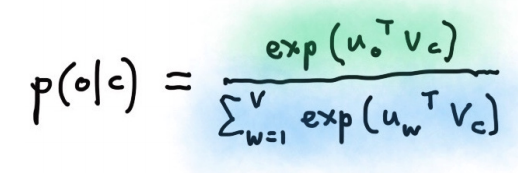

In [ ]:
class Skipgram(nn.Module):
    
    def __init__(self, vocab_size, projection_dim):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim)
        self.embedding_u = nn.Embedding(vocab_size, projection_dim)

        self.embedding_v.weight.data.uniform_(-1, 1) # init
        self.embedding_u.weight.data.uniform_(0, 0) # init
        #self.out = nn.Linear(projection_dim,vocab_size)
    def forward(self, center_words,target_words, outer_words):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        outer_embeds = self.embedding_u(outer_words) # B x V x D
        
        scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # Bx1xD * BxDx1 => Bx1
        norm_scores = outer_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # BxVxD * BxDx1 => BxV
        
        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        
        return nll # negative log likelihood
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds 

#### Train  

In [ ]:
EMBEDDING_SIZE = 30
BATCH_SIZE = 256
EPOCH = 400

In [ ]:
losses = []
model = Skipgram(len(word2index), EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(EPOCH):
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        inputs, targets = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        vocabs = prepare_sequence(list(vocab), word2index).expand(inputs.size(0), len(vocab))  # B x V
        model.zero_grad()

        loss = model(inputs, targets, vocabs)
        
        loss.backward()
        optimizer.step()
           
        #print(loss.data.tolist())
        #loss = torch.cuda.FloatTensor(loss)
        #print(loss.item()[0])
        #losses.append(loss.data.tolist()[0])
        #losses.append(loss.data.tolist())
        losses.append(loss.item())

    if epoch % 10 == 0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch,np.mean(losses)))
        losses = []

#### Test

In [ ]:
def word_similarity(target, vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target, word2index))
    else:
        target_V = model.prediction(prepare_word(target, word2index))
    similarities = []
    for i in range(len(vocab)):
        if vocab[i] == target: continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        cosine_sim = F.cosine_similarity(target_V, vector).data.tolist()[0] 
        similarities.append([vocab[i], cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10] # sort by similarity

In [ ]:
test = random.choice(list(vocab))
test

In [ ]:
word_similarity(test, vocab)

#### 2. Skip-gram with negative sampling

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [ ]:
print(torch.__version__)
print(nltk.__version__)

In [ ]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [ ]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

- Data load and Preprocessing 

In [ ]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

- Exclude sparse words 

In [ ]:
word_count = Counter(flatten(corpus))

In [ ]:
MIN_COUNT = 3
exclude = []

In [ ]:
for w, c in word_count.items():
    if c < MIN_COUNT:
        exclude.append(w)

- Prepare train data 

In [ ]:
vocab = list(set(flatten(corpus)) - set(exclude))

In [ ]:
word2index = {}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

In [ ]:
WINDOW_SIZE = 5
windows =  flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in corpus])

train_data = []

for window in windows:
    for i in range(WINDOW_SIZE * 2 + 1):
        if window[i] in exclude or window[WINDOW_SIZE] in exclude: 
            continue # min_count
        if i == WINDOW_SIZE or window[i] == '<DUMMY>': 
            continue
        train_data.append((window[WINDOW_SIZE], window[i]))

X_p = []
y_p = []

for tr in train_data:
    X_p.append(prepare_word(tr[0], word2index).view(1, -1))
    y_p.append(prepare_word(tr[1], word2index).view(1, -1))
    
train_data = list(zip(X_p, y_p))

In [ ]:
len(train_data)

- Build Unigram Distribution**0.75 

$$P(w)=U(w)^{3/4}/Z$$

- 3/4라는 지수의 역할 : 빈도가 낮은 단어가 샘플링될 확률을 높여줌(Negative Sample)

In [ ]:
Z = 0.001

In [ ]:
word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items() if w not in exclude])

In [ ]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [ ]:
print(len(vocab), len(unigram_table))

- Negative Sampling 

In [ ]:
def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].data.cpu().tolist()[0] if USE_CUDA else targets[i].data.tolist()[0]
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    
    return torch.cat(neg_samples)

- Modeling 

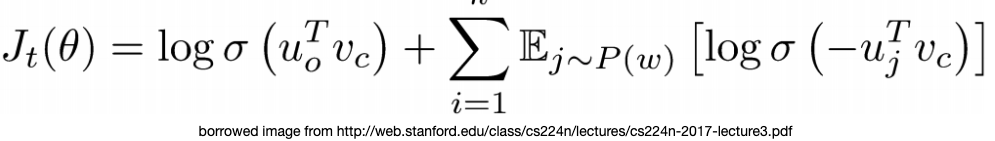

In [ ]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, projection_dim):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                
        initrange = (2.0 / (vocab_size + projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-0.0, 0.0) # init
        
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        
        neg_embeds = -self.embedding_u(negative_words) # B x K x D
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # Bx1
        negative_score = torch.sum(neg_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2), 1).view(negs.size(0), -1) # BxK -> Bx1
        
        loss = self.logsigmoid(positive_score) + self.logsigmoid(negative_score)
        
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

- Train 

In [ ]:
EMBEDDING_SIZE = 30 
BATCH_SIZE = 256
EPOCH = 100
NEG = 10 # Num of Negative Sampling

In [ ]:
losses = []
model = SkipgramNegSampling(len(word2index), EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(EPOCH):
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        inputs, targets = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        negs = negative_sampling(targets, unigram_table, NEG)
        model.zero_grad()

        loss = model(inputs, targets, negs)
        
        loss.backward()
        optimizer.step()
    
        #losses.append(loss.data.tolist()[0])
        losses.append(loss.data.tolist())
        
    if epoch % 10 == 0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch, np.mean(losses)))
        losses = []

- Test

In [ ]:
def word_similarity(target, vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target, word2index))
    else:
        target_V = model.prediction(prepare_word(target, word2index))
    similarities = []
    for i in range(len(vocab)):
        if vocab[i] == target: 
            continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        
        cosine_sim = F.cosine_similarity(target_V, vector).data.tolist()[0]
        similarities.append([vocab[i], cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
test = random.choice(list(vocab))
test

In [ ]:
word_similarity(test, vocab)

## Robust Word2Vec Models with Gensim

- While our implementations are decent enough, they are not optimized enough to work well on large corpora. 
- The **gensim** framework, created by Radim Řehůřek consists of a robust, efficient and scalable implementation of the Word2Vec model. 
- We will leverage the same on Bible corpus. 
- In our workflow, we will tokenize our normalized corpus and then focus on the following four parameters in the Word2Vec model to build it.
    - size: The word embedding dimensionality
    - window: The context window size
    - min_count: The minimum word count
    - sample: The downsample setting for frequent words
- After building our model, we will use our words of interest to see the top similar words for each of them.

- Let’s now load up our other corpus based on The King James Version of the Bible using nltk and pre-process the text.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.corpus import gutenberg
from string import punctuation

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)



In [ ]:
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

In [ ]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

- The similar words here definitely are more related to our words of interest and this is expected given that we ran this model for more number of iterations which must have yield better and more contextual embeddings. 
- Do you notice any interesting associations?
![](https://miro.medium.com/max/1064/1*FaXo2UCuoGGWw6ryRXCEWA.png)

- Let’s also visualize the words of interest and their similar words using their embedding vectors after reducing their dimensions to a 2-D space with t-SNE.

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

- We can clearly see based on what I depicted earlier that noah and his sons are quite close to each other based on the word embeddings from our model!

## Applying Word2Vec features for Machine Learning Tasks

-  Let’s try to apply word2vec features to actual machine learning task like clustering.
- To start with, we will build a simple Word2Vec model on the corpus and visualize the embeddings.


In [ ]:
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

In [ ]:
norm_corpus = normalize_corpus(corpus)
norm_corpus

In [ ]:
# build word2vec model
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_corpus]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
                              
                              
# visualize embeddings
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

- Remember that our corpus is extremely small so to get meaninful word embeddings and for the model to get more context and semantics, more data helps. 
- Now what is a word embedding in this scenario? It’s typically a dense vector for each word as depicted in the following example for the word **sky**.

In [ ]:
w2v_model.wv['sky']

- Now suppose we wanted to cluster the eight documents from our toy corpus, we would need to get the document level embeddings from each of the words present in each document. 
- One strategy would be to average out the word embeddings for each word in a document. 
- This is an extremely useful strategy and you can adopt the same for your own problems. 
- Let’s apply this now on our corpus to get features for each document.


In [ ]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

- Now that we have our features for each document, let’s cluster these documents using the **Affinity Propagation** algorithm, which is a clustering algorithm based on the concept of “message passing” between data points and does not need the number of clusters as an explicit input which is often required by partition-based clustering algorithms.


In [ ]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(w2v_feature_array)
cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
pd.concat([corpus_df, cluster_labels], axis=1)

- We can see that our algorithm has clustered each document into the right group based on our Word2Vec features.
- Pretty neat! We can also visualize how each document in positioned in each cluster by using Principal Component Analysis (PCA) to reduce the feature dimensions to 2-D and then visualizing the same (by color coding each cluster).

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
pcs = pca.fit_transform(w2v_feature_array)
labels = ap.labels_
categories = list(corpus_df['Category'])
plt.figure(figsize=(8, 6))

for i in range(len(labels)):
    label = labels[i]
    color = 'orange' if label == 0 else 'blue' if label == 1 else 'green'
    annotation_label = categories[i]
    x, y = pcs[i]
    plt.scatter(x, y, c=color, edgecolors='k')
    plt.annotate(annotation_label, xy=(x+1e-4, y+1e-3), xytext=(0, 0), textcoords='offset points')

- Everything looks to be in order as documents in each cluster are closer to each other and far apart from other clusters.

## The GloVe Model

- The GloVe model stands for Global Vectors which is an unsupervised learning model which can be used to obtain dense word vectors similar to Word2Vec. 
- However the technique is different and training is performed on an aggregated **global word-word co-occurrence matrix**, giving us a vector space with meaningful sub-structures. 
- This method was invented in Stanford by Pennington et al. and I recommend you to read the original paper on GloVe, ‘GloVe: Global Vectors for Word Representation’ by Pennington et al. which is an excellent read to get some perspective on how this model works.

- The basic methodology of the GloVe model is to first create a huge word-context co-occurence matrix consisting of (word, context) pairs such that each element in this matrix represents how often a word occurs with the context (which can be a sequence of words). The idea then is to apply matrix factorization to approximate this matrix as depicted in the following figure.

![](https://miro.medium.com/max/815/1*UNtsSilztKXjLG99VXxSQw.png)

- Considering the Word-Context (WC) matrix, Word-Feature (WF) matrix and Feature-Context (FC) matrix, we try to factorize WC = WF x FC, such that we we aim to reconstruct WC from WF and FC by multiplying them. 
- For this, we typically initialize WF and FC with some random weights and attempt to multiply them to get WC’ (an approximation of WC) and measure how close it is to WC. 
- We do this multiple times using Stochastic Gradient Descent (SGD) to minimize the error. 
- Finally, the Word-Feature matrix (WF) gives us the word embeddings for each word where F can be preset to a specific number of dimensions. 
- A very important point to remember is that both Word2Vec and GloVe models are very similar in how they work. 
- Both of them aim to build a vector space where the position of each word is influenced by its neighboring words based on their context and semantics. 
- Word2Vec starts with local individual examples of word co-occurrence pairs and GloVe starts with global aggregated co-occurrence statistics across all words in the corpus.

### Glove Implementation
- taken from https://github.com/DSKSD/DeepNLP-models-Pytorch/tree/master/notebooks

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [ ]:
print(torch.__version__)
print(nltk.__version__)

In [ ]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [ ]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex:eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

def prepare_word(word, word2index):
    return Variable(LongTensor([word2index[word]]) if word2index.get(word) is not None else LongTensor([word2index["<UNK>"]]))

#### Data load and Preprocessing 

In [ ]:
corpus = list(nltk.corpus.gutenberg.sents('melville-moby_dick.txt'))[:500]
corpus = [[word.lower() for word in sent] for sent in corpus]

#### Build vocab

In [ ]:
vocab = list(set(flatten(corpus)))

In [ ]:
word2index = {}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word={v:k for k, v in word2index.items()}

In [ ]:
WINDOW_SIZE = 5
windows =  flatten([list(nltk.ngrams(['<DUMMY>'] * WINDOW_SIZE + c + ['<DUMMY>'] * WINDOW_SIZE, WINDOW_SIZE * 2 + 1)) for c in corpus])

window_data = []

for window in windows:
    for i in range(WINDOW_SIZE * 2 + 1):
        if i == WINDOW_SIZE or window[i] == '<DUMMY>': 
            continue
        window_data.append((window[WINDOW_SIZE], window[i]))


### Weighting Function

특정 단어 간의 Co-occurrence는 다른 것들에 비해 과하게 높을 수가 있다. 그래서 Co-occurrence가 너무 큰 경우의 영향을 줄이기 위한 Weighting Function 을 사용합니다(f(P_{ij})

#### Weighting Function
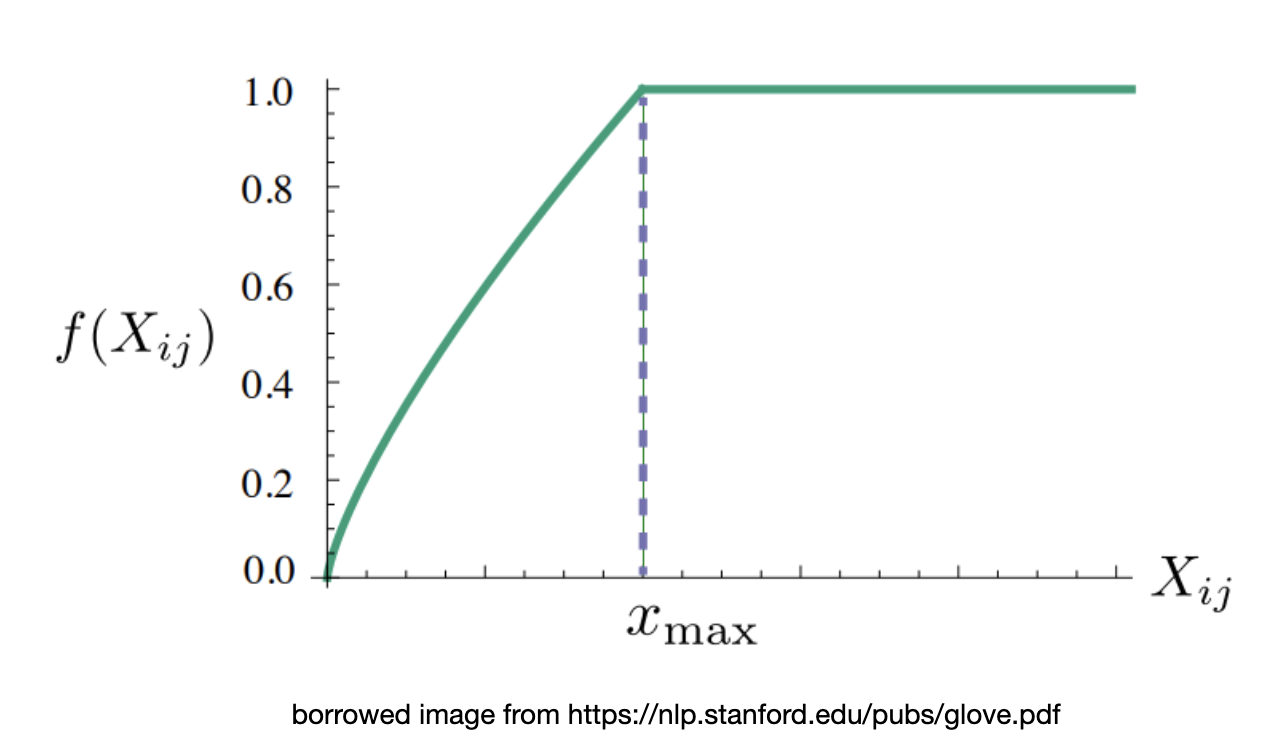

In [ ]:
def weighting(w_i, w_j):
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1
        
    x_max = 100 #100 # fixed in paper
    alpha = 0.75
    
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha
    else:
        result = 1
    
    return result

#### Build Co-occurence Matrix X

- Because of model complexity, It is important to determine whether a tighter bound can be placed on the number of nonzero elements of X.

In [ ]:
X_i = Counter(flatten(corpus)) # X_i

In [ ]:
X_ik_window_5 = Counter(window_data) # Co-occurece in window size 5

In [ ]:
X_ik = {}
weighting_dic = {}

In [ ]:
from itertools import combinations_with_replacement

In [ ]:
for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_window_5.get(bigram) is not None: # nonzero elements
        co_occer = X_ik_window_5[bigram]
        X_ik[bigram] = co_occer + 1 # log(Xik) -> log(Xik+1) to prevent divergence
        X_ik[(bigram[1],bigram[0])] = co_occer+1
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1])
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0])

In [ ]:
test = random.choice(window_data)
print(test)
try:
    print(X_ik[(test[0], test[1])] == X_ik[(test[1], test[0])])
except:
    1

#### Prepare train data

In [ ]:
u_p = [] # center vec
v_p = [] # context vec
co_p = [] # log(x_ij)
weight_p = [] # f(x_ij)

for pair in window_data: 
    u_p.append(prepare_word(pair[0], word2index).view(1, -1))
    v_p.append(prepare_word(pair[1], word2index).view(1, -1))
    
    try:
        cooc = X_ik[pair]
    except:
        cooc = 1

    co_p.append(torch.log(Variable(FloatTensor([cooc]))).view(1, -1))
    weight_p.append(Variable(FloatTensor([weighting_dic[pair]])).view(1, -1))
                                  
train_data = list(zip(u_p, v_p, co_p, weight_p))
del u_p
del v_p
del co_p
del weight_p
print(train_data[0]) # tuple (center vec i, context vec j log(x_ij), weight f(w_ij))

#### Modeling
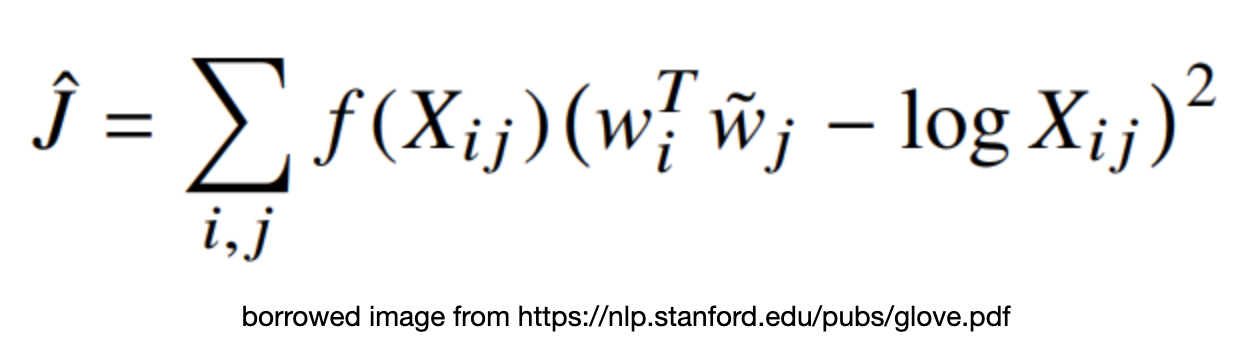

In [ ]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,projection_dim):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, projection_dim) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, projection_dim) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
        initrange = (2.0 / (vocab_size + projection_dim))**0.5 # Xavier init
        self.embedding_v.weight.data.uniform_(-initrange, initrange) # init
        self.embedding_u.weight.data.uniform_(-initrange, initrange) # init
        self.v_bias.weight.data.uniform_(-initrange, initrange) # init
        self.u_bias.weight.data.uniform_(-initrange, initrange) # init
        
    def forward(self, center_words, target_words, coocs, weights):
        center_embeds = self.embedding_v(center_words) # B x 1 x D
        target_embeds = self.embedding_u(target_words) # B x 1 x D
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2) # Bx1
        
        loss = weights*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)
    
    def prediction(self, inputs):
        v_embeds = self.embedding_v(inputs) # B x 1 x D
        u_embeds = self.embedding_u(inputs) # B x 1 x D
                
        return v_embeds+u_embeds # final embed

#### Train

In [ ]:
EMBEDDING_SIZE = 50
BATCH_SIZE = 256
EPOCH = 50

In [ ]:
losses = []
model = GloVe(len(word2index), EMBEDDING_SIZE)
if USE_CUDA:
    model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(EPOCH):
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        
        inputs, targets, coocs, weights = zip(*batch)
        
        inputs = torch.cat(inputs) # B x 1
        targets = torch.cat(targets) # B x 1
        coocs = torch.cat(coocs)
        weights = torch.cat(weights)
        model.zero_grad()

        loss = model(inputs, targets, coocs, weights)
        
        loss.backward()
        optimizer.step()
    
        #losses.append(loss.data.tolist()[0])
        losses.append(loss.data.tolist())
    if epoch % 10 == 0:
        print("Epoch : %d, mean_loss : %.02f" % (epoch, np.mean(losses)))
        losses = []

#### Test

In [ ]:
def word_similarity(target, vocab):
    if USE_CUDA:
        target_V = model.prediction(prepare_word(target, word2index))
    else:
        target_V = model.prediction(prepare_word(target, word2index))
    similarities = []
    for i in range(len(vocab)):
        if vocab[i] == target: 
            continue
        
        if USE_CUDA:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        else:
            vector = model.prediction(prepare_word(list(vocab)[i], word2index))
        
        cosine_sim = F.cosine_similarity(target_V, vector).data.tolist()[0] 
        similarities.append([vocab[i], cosine_sim])
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:10]

In [ ]:
test = random.choice(list(vocab))
test

In [ ]:
word_similarity(test, vocab)

### Applying GloVe features for Machine Learning Tasks

- Let’s try and leverage GloVe based embeddings for our document clustering task. 
- The very popular spacy framework comes with capabilities to leverage GloVe embeddings based on different language models. 
- You can also get pre-trained word vectors and load them up as needed using gensim or spacy. 
- We will first install spacy and use the en_vectors_web_lg model which consists of 300-dimensional word vectors trained on Common Crawl with GloVe.

In [ ]:
# Download the following language model and store it in disk
!wget https://github.com/explosion/spacy-models/releases/tag/en_vectors_web_lg-2.0.0

In [ ]:
# Link the same to spacy 
! python3 -m spacy link ./spacymodels/en_vectors_web_lg-2.0.0/en_vectors_web_lg en_vecs

In [ ]:
import spacy

nlp = spacy.load('en_vecs')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

## Applying FastText features for Machine Learning Tasks
- The gensim package has nice wrappers providing us interfaces to leverage the FastText model available under the gensim.models.fasttext module.
- Let’s apply this once again on our Bible corpus and look at our words of interest and their most similar words.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline

In [ ]:
from nltk.corpus import gutenberg
from string import punctuation

wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)


In [ ]:
bible = gutenberg.sents('bible-kjv.txt') 
remove_terms = punctuation + '0123456789'

norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

print('Total lines:', len(bible))
print('\nSample line:', bible[10])
print('\nProcessed line:', norm_bible[10])

In [ ]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

# sg decides whether to use the skip-gram model (1) or CBOW (0)
ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)
                    
                    
# view similar words based on gensim's FastText model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words                    

- You can see a lot of similarity in the results with our Word2Vec model with relevant similar words for each of our words of interest. 
- Do you notice any interesting associations and similarities?
![](https://miro.medium.com/max/868/1*-9s6TOw0lySpMQsMcDWPNA.png)

- Let’s now use Principal Component Analysis (PCA) to reduce the word embedding dimensions to 2-D and then visualize the same.

In [ ]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

- We can see a lot of interesting patterns! Noah, his son Shem and grandfather Methuselah are close to each other. 
- We also see God associated with Moses and Egypt where it endured the Biblical plagues including famine and pestilence. 
- Also Jesus and some of his disciples are associated close to each other.

- To access any of the word embeddings you can just index the model with the word as follows.

In [ ]:
ft_model.wv['jesus']

- Having these embeddings, we can perform some interesting natural language tasks. 
- One of these would be to find out similarity between different words (entities).

In [ ]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

- We can see that ‘god’ is more closely associated with ‘jesus’ rather than ‘satan’ based on the text in our Bible corpus. Quite relevant!

- Considering word embeddings being present, we can even find out odd words from a bunch of words as follows.

In [ ]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:',  
      ft_model.wv.doesnt_match(st1.split()))
st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', 
      ft_model.wv.doesnt_match(st2.split()))